## Compile the redox potentials
We want to see what the energy differences for different methods are and compare the runtimes

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import linregress, siegelslopes
from ase.db import connect
import pandas as pd
import numpy as np

## Load the Database into Pandas
Get the energies for each system for each CP2K setting

In [2]:
example_molecules = pd.read_csv('../data/example_molecules.csv')

In [3]:
mol_props = example_molecules.set_index('inchi_key').to_dict('index')

In [4]:
data = []
for psolver in ['mt-all', 'wavelet-all']:
    with connect(f'{psolver}/data.db') as db:
        for row in db.select(''):
            record = row.key_value_pairs.copy()
            record['basis_set'] = record['basis_set'].upper()
            record['n_electrons'] = mol_props[record['inchi_key']]['n_electrons']
            record['energy'] = row.energy
            record['solver'] = psolver
            record['gpu'] = row.key_value_pairs.get('gpu', True)
            data.append(record)
data = pd.DataFrame(data)
print(f'Loaded {len(data)} computations')

Loaded 36 computations


## Compute the redox potentials
Get the energy differences between different stats

In [5]:
method_keys = ['solver', 'basis_set', 'xc', 'cutoff', 'buffer', 'gpu']
records = []
for lid, (level, subset) in enumerate(data.groupby(method_keys)):
    method_desc = dict(zip(method_keys, level))
    
    # Match states
    neutrals = subset.query('state=="neutral"')
    for state in ['oxidized', 'reduced']:
        redoxed = subset.query(f'state=="{state}"')
        merged = redoxed.merge(neutrals, on=('inchi_key', 'xc', 'cutoff'))
        
        # Create a record for each
        for _, row in merged.iterrows():
            record = {}
            record['inchi_key'] = row['inchi_key']
            record['state'] = state
            record['potential'] = row['energy_x'] - row['energy_y']
            record['runtime'] = row['runtime_x'] + row['runtime_y']
            record['level_id'] = lid
            record['n_electrons'] = row['n_electrons_x']
            record.update(method_desc)
            records.append(record)
records = pd.DataFrame(records)

### Compare to NWChem
Get the all-electron results (GAPW)

In [6]:
gapw_params = {'solver': 'mt-all', 'xc': 'HYB_GGA_XC_B3LYP'}

In [7]:
gapw_records = records.copy()
gapw_params.pop('basis_set', None)
for k, v in gapw_params.items():
    gapw_records = gapw_records[gapw_records[k] == v]
print(f'Reduced to {len(gapw_records)} results for All electron')
gapw_records.head(2)

Reduced to 23 results for All electron


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer,gpu
0,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.609369,176.995594,0,6,mt-all,DEF2-SVP,HYB_GGA_XC_B3LYP,300,6.0,True
1,IJDNQMDRQITEOD-UHFFFAOYSA-N,oxidized,10.192664,697.758964,0,24,mt-all,DEF2-SVP,HYB_GGA_XC_B3LYP,300,6.0,True


In [8]:
chosen = gapw_records
print(f'Ran CP2K for {len(chosen.inchi_key.value_counts())} molecules')

Ran CP2K for 8 molecules


In [9]:
nwchem_results = pd.read_csv('../nwchem/nwchem-redox-potentials.csv')
print(f'Ran NWChem for {len(nwchem_results.inchi_key.value_counts())} molecules')

Ran NWChem for 12 molecules


Compare to NWChem

In [10]:
matched_basis = [('DEF2-SVP', 'def2-svp'), ('DEF2-TZVPD', 'def2-tzvpd')]

In [11]:
nwchem_results.basis_set.value_counts()

aug-cc-pvdz    42
6-31g**        24
cc-pvdz        24
def2-svp       14
def2-tzvpd     14
Name: basis_set, dtype: int64

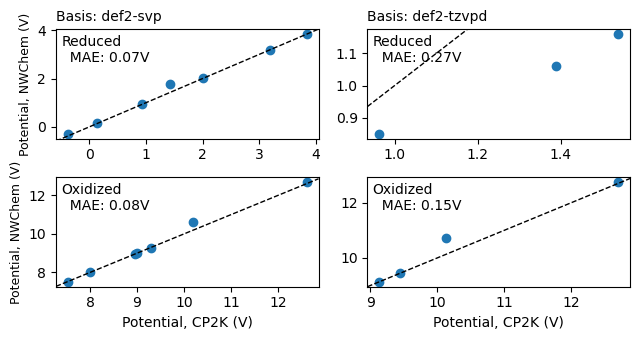

In [12]:
fig, axs = plt.subplots(2, len(matched_basis), figsize=(6.5, 3.5))

for ax, (cp2k_basis, nwc_basis) in zip(axs[:, :].T, matched_basis):
    ax[0].set_title(f'Basis: {nwc_basis}', fontsize=10, loc='left')
    nwchem_subset = nwchem_results.query(f'basis_set=="{nwc_basis}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    for a, s in zip(ax, ['reduced', 'oxidized']): 
        subset = merged.query(f'state=="{s}"')
        a.scatter(subset['potential_x'], subset['potential_y'], label=s)
        mae = (subset['potential_x'] - subset['potential_y']).abs().mean()
    
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
    
        a.plot(a.get_xlim(), a.get_xlim(), 'k--', lw=1)
        
        a.text(0.02, 0.95, s.capitalize() + f'\n  MAE: {mae:.2f}V', ha='left', va='top', transform=a.transAxes)
    
    ax[-1].set_xlabel('Potential, CP2K (V)')
    
for ax in axs[:, 0]:
    ax.set_ylabel('Potential, NWChem (V)', fontsize=9)
    
fig.tight_layout()

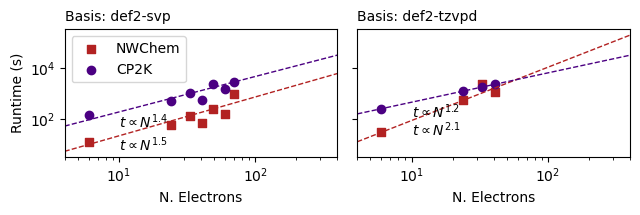

In [13]:
fig, axs = plt.subplots(1, len(matched_basis), sharey=True, sharex=True, figsize=(6.5, 2.25))

for ax, (cp2k_basis, nwc_basis) in zip(axs, matched_basis):
    nwchem_subset = nwchem_results.query(f'basis_set=="{nwc_basis}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    subset = merged.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='NWChem')
    nwc_linreg = siegelslopes(np.log(subset['runtime_y']), np.log(subset.index))
    ax.text(10, np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{nwc_linreg.slope:.1f}}}$', va='top')
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='CP2K')
    cpk_linreg = siegelslopes(np.log(subset['runtime_x']), np.log(subset.index))
    ax.text(10, np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{cpk_linreg.slope:.1f}}}$', va='top')
    
    # Set up the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Plot the linear regressions
    ax.set_xlim([4, 400])
    ax.plot(ax.get_xlim(), np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_xlabel('N. Electrons')
    ax.set_title(f'Basis: {nwc_basis}', fontsize=10, loc='left')

axs[0].set_ylabel('Runtime (s)')
axs[0].legend()
fig.tight_layout()